In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from sklearn.model_selection import train_test_split

random_seed = 42
torch.manual_seed(random_seed)

In [12]:
import torchvision
from torchinfo import summary

vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_base_12 = torchvision.models.vit_b_16(weights=vit_weights)


In [13]:
vit_transforms = vit_weights.transforms()

data_dir = '../EuroSAT/2750'
eurosat_dataset = datasets.ImageFolder(data_dir, transform=vit_transforms)
eurosat_dataset


Dataset ImageFolder
    Number of datapoints: 27000
    Root location: ../EuroSAT/2750
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [14]:
from torch.utils.data import DataLoader, random_split

#split into 80,10,10
total_size = len(eurosat_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    eurosat_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create DataLoader instances for train, validation, and test sets
batch_size = 1

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size*1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size*1, shuffle=False)

In [15]:
eurosat_dataset.class_to_idx
idx_to_class = {v: k for k, v in eurosat_dataset.class_to_idx.items()}
idx_to_class

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

In [16]:
class EuroSAT_ViTBase12(nn.Module):
    def __init__(self):
        super(EuroSAT_ViTBase12, self).__init__()
        self.eurosat = vit_base_12  
        self.eurosat.heads = nn.Linear(768, 10)  # Change output layer to have 10 classes

    def forward(self, x):
        return self.eurosat(x)


In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
class CustomEncoderBlock(nn.Module):
    def __init__(self, encoder_block):
        super(CustomEncoderBlock, self).__init__()
        # Copy the relevant attributes from the original encoder block
        self.ln_1 = encoder_block.ln_1
        self.self_attention = encoder_block.self_attention
        self.dropout = encoder_block.dropout
        self.ln_2 = encoder_block.ln_2
        self.mlp = encoder_block.mlp

    def forward(self, input):
        x = self.ln_1(input)
        x, attention_weight = self.self_attention(x, x, x, need_weights=True,average_attn_weights=True)
        x = self.dropout(x)
        x = x + input

        y = self.ln_2(x)
        y = self.mlp(y)
        return x + y

# Modify the pretrained_model's encoder blocks using the custom class

class ViTWithAttention(nn.Module):
    def __init__(self, vit_model):
        super(ViTWithAttention, self).__init__()
        self.vit = vit_model
        self.attention_maps = []  # Initialize a list to store attention maps
        # self.numpy_attention = np.array()
        # Register a forward hook to capture attention maps
        def hook(module, input, output):
            # np.append(self.attention_maps,output)
            self.attention_maps.append(output)

        for i, encoder_block in enumerate(self.vit.eurosat.encoder.layers):
            self.vit.eurosat.encoder.layers[i] = CustomEncoderBlock(encoder_block)  

        for block in self.vit.eurosat.encoder.layers:
            # Replace the original EncoderBlock with the modified one
            block.self_attention.register_forward_hook(hook)
        

    def forward(self, x):
        # Clear the list of attention maps before each forward pass
        self.attention_maps = []
        outputs = self.vit(x)
        return outputs


In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchinfo import summary

# Instantiate the modified ViT model
def pre_process_image(path):
    img = Image.open(path)
    image_tensor = vit_transforms(img)
    #If it is train_loader
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    return image_tensor,img

def get_attention_matrix(model_name):
    model = ViTWithAttention(model_name)
    model.eval()
    # Forward pass to get model outputs and capture attention maps
    with torch.no_grad():
        outputs = model(image_tensor)
        # print(outputs.data)
        _, predicted = torch.max(outputs.data, 1)

    # print(len(model.attention_maps))
        model_attention_maps = model.attention_maps.copy()
    # print(len(model_attention_maps))
    return model_attention_maps,predicted

def get_model(path):
    model = EuroSAT_ViTBase12()
    model.load_state_dict(torch.load(path))
    model = model.to(device)
    return model

def plot_attention(original_image,attentions_list, titles):
    num_models = len(attentions_list)
    num_layers = len(attentions_list[0])
    num_rows = num_layers   # Add 1 for the original image
    num_cols = num_models

    plt.figure(figsize=(3,3))
    plt.imshow(original_img, cmap='inferno')
    plt.title("Original Image")
    plt.show()  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))

    # Iterate through each transformer layer
    for layer in range(num_layers):
        row_label = f'Layer-{layer}'
        axes[layer, 0].text(-0.5, 0.5, row_label, fontsize=16, va='center', ha='center', transform=axes[layer, 0].transAxes)

        for model in range(num_models):
            attention_map = attentions_list[model][layer]
            ax = axes[layer, model]
            ax.imshow(attention_map.squeeze(), cmap='inferno')
            ax.axis('off')
            ax.set_title(titles[model],fontsize=13)

    plt.tight_layout()
    plt.show()

def convert_attention_to_plot(attention_map,w_featmap,h_featmap):
    layer_attentions = []
    patch_size=16
    # print(len(attention_map))
    for i, attention_weight in enumerate(attention_map):

        # Get the number of attention heads and sequence length
        attentions = attention_weight[1]
        # print(attentions.shape)
        
        nh = 1  # number of head
        
        attentions = attentions[0, 0, 1:].reshape(nh, -1)

        attentions = attentions.reshape(nh, w_featmap, h_featmap)
        attentions = nn.functional.interpolate(attentions.unsqueeze(
            0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

        # print(attentions.shape)
        layer_attentions.append(attentions)
        # plot_attention(img,attentions)
    return layer_attentions

def visualize_all_model(image_tensor,original_image,Ground_Truth):
    

    patch_size = 16
    w, h = image_tensor.shape[1] - image_tensor.shape[1] % patch_size, image_tensor.shape[2] - \
            image_tensor.shape[2] % patch_size

    image_tensor = image_tensor[:, :w, :h].unsqueeze(0)

    w_featmap = image_tensor.shape[-2] // patch_size
    h_featmap = image_tensor.shape[-1] // patch_size


    model_last_layer_FT = EuroSAT_ViTBase12()
    model_last_layer_FT.load_state_dict(torch.load("eurosat-vit-base12-last-layer-tune.pth"))
    model_last_layer_FT = model_last_layer_FT.to(device)

    last_layer_FT_attention,out_ll = get_attention_matrix(model_last_layer_FT)
    last_layer_FT_attention = convert_attention_to_plot(last_layer_FT_attention,w_featmap,h_featmap)
    

    model_bottom_layer_FT = EuroSAT_ViTBase12()
    model_bottom_layer_FT.load_state_dict(torch.load("eurosat-vit-base12-bottom-layer-tune.pth"))
    model_bottom_layer_FT = model_bottom_layer_FT.to(device)

    bottom_layer_FT_attention,out_bl = get_attention_matrix(model_bottom_layer_FT)
    bottom_layer_FT_attention = convert_attention_to_plot(bottom_layer_FT_attention,w_featmap,h_featmap)
    

    model_all_layer_FT = EuroSAT_ViTBase12()
    model_all_layer_FT.load_state_dict(torch.load("eurosat-vit-base12-full-fine-tune.pth"))
    model_all_layer_FT = model_all_layer_FT.to(device)

    all_layer_FT_attention,out_all = get_attention_matrix(model_all_layer_FT)
    all_layer_FT_attention = convert_attention_to_plot(all_layer_FT_attention,w_featmap,h_featmap)
    
    model_do_not_FT = EuroSAT_ViTBase12()
    model_do_not_FT.load_state_dict(torch.load("eurosat-vit-base12-do-not-fine-tune.pth"))
    model_do_not_FT = model_do_not_FT.to(device)

    do_not_FT_attention,out_dnt = get_attention_matrix(model_do_not_FT)
    do_not_FT_attention = convert_attention_to_plot(do_not_FT_attention,w_featmap,h_featmap)

    print("Prediction:")
    print("Last Layer Fine Tune only: ",idx_to_class[out_ll.item()])
    print("Bottom Layer Fine Tune only: ",idx_to_class[out_bl.item()])
    print("All layer Tune only: ",idx_to_class[out_all.item()])
    print("Do not Fine-tune: ",idx_to_class[out_dnt.item()])
    print("Ground Truth: ",Ground_Truth)

    # Define titles for each model
    titles = ['Last Layer FT', 'Bottom Layer FT', 'All Layer FT', 'Do Not FT']
    
    # Visualize the attention maps
    plot_attention(original_image,[last_layer_FT_attention,
                            bottom_layer_FT_attention,
                            all_layer_FT_attention,
                            do_not_FT_attention],
                            titles)

# Label: Pasture

Prediction:
Last Layer Fine Tune only:  Pasture
Bottom Layer Fine Tune only:  Pasture
All layer Tune only:  Pasture
Do not Fine-tune:  HerbaceousVegetation
Ground Truth:  Pasture


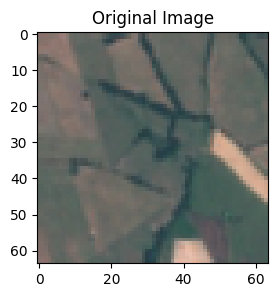

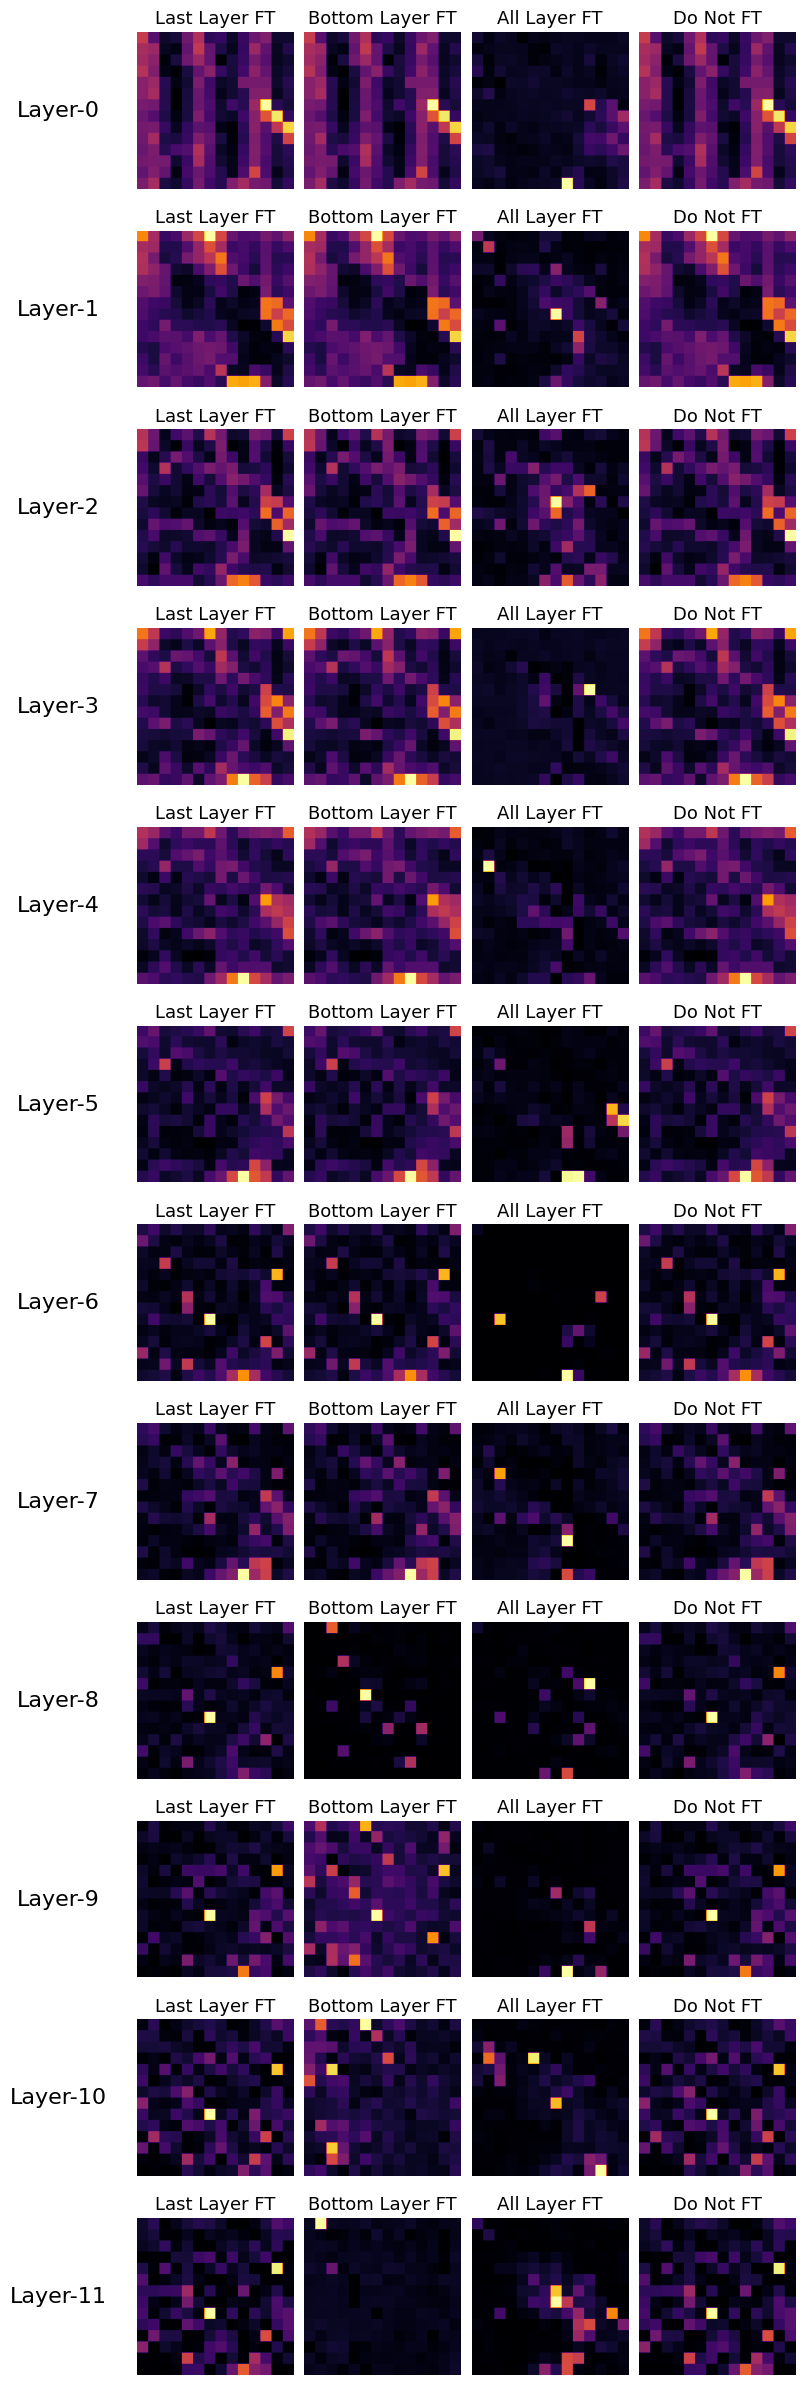

In [20]:
path = "../EuroSAT/2750/Pasture/Pasture_15.jpg"
Ground_Truth = "Pasture"
image_tensor,original_img = pre_process_image(path)
visualize_all_model(image_tensor,original_img,Ground_Truth)

# Label: AnnualCrop

Prediction:
Last Layer Fine Tune only:  AnnualCrop
Bottom Layer Fine Tune only:  AnnualCrop
All layer Tune only:  AnnualCrop
Do not Fine-tune:  River
Ground Truth:  AnnualCrop


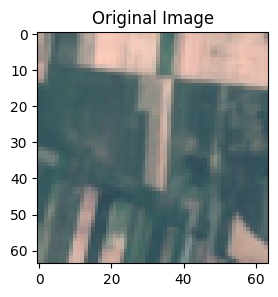

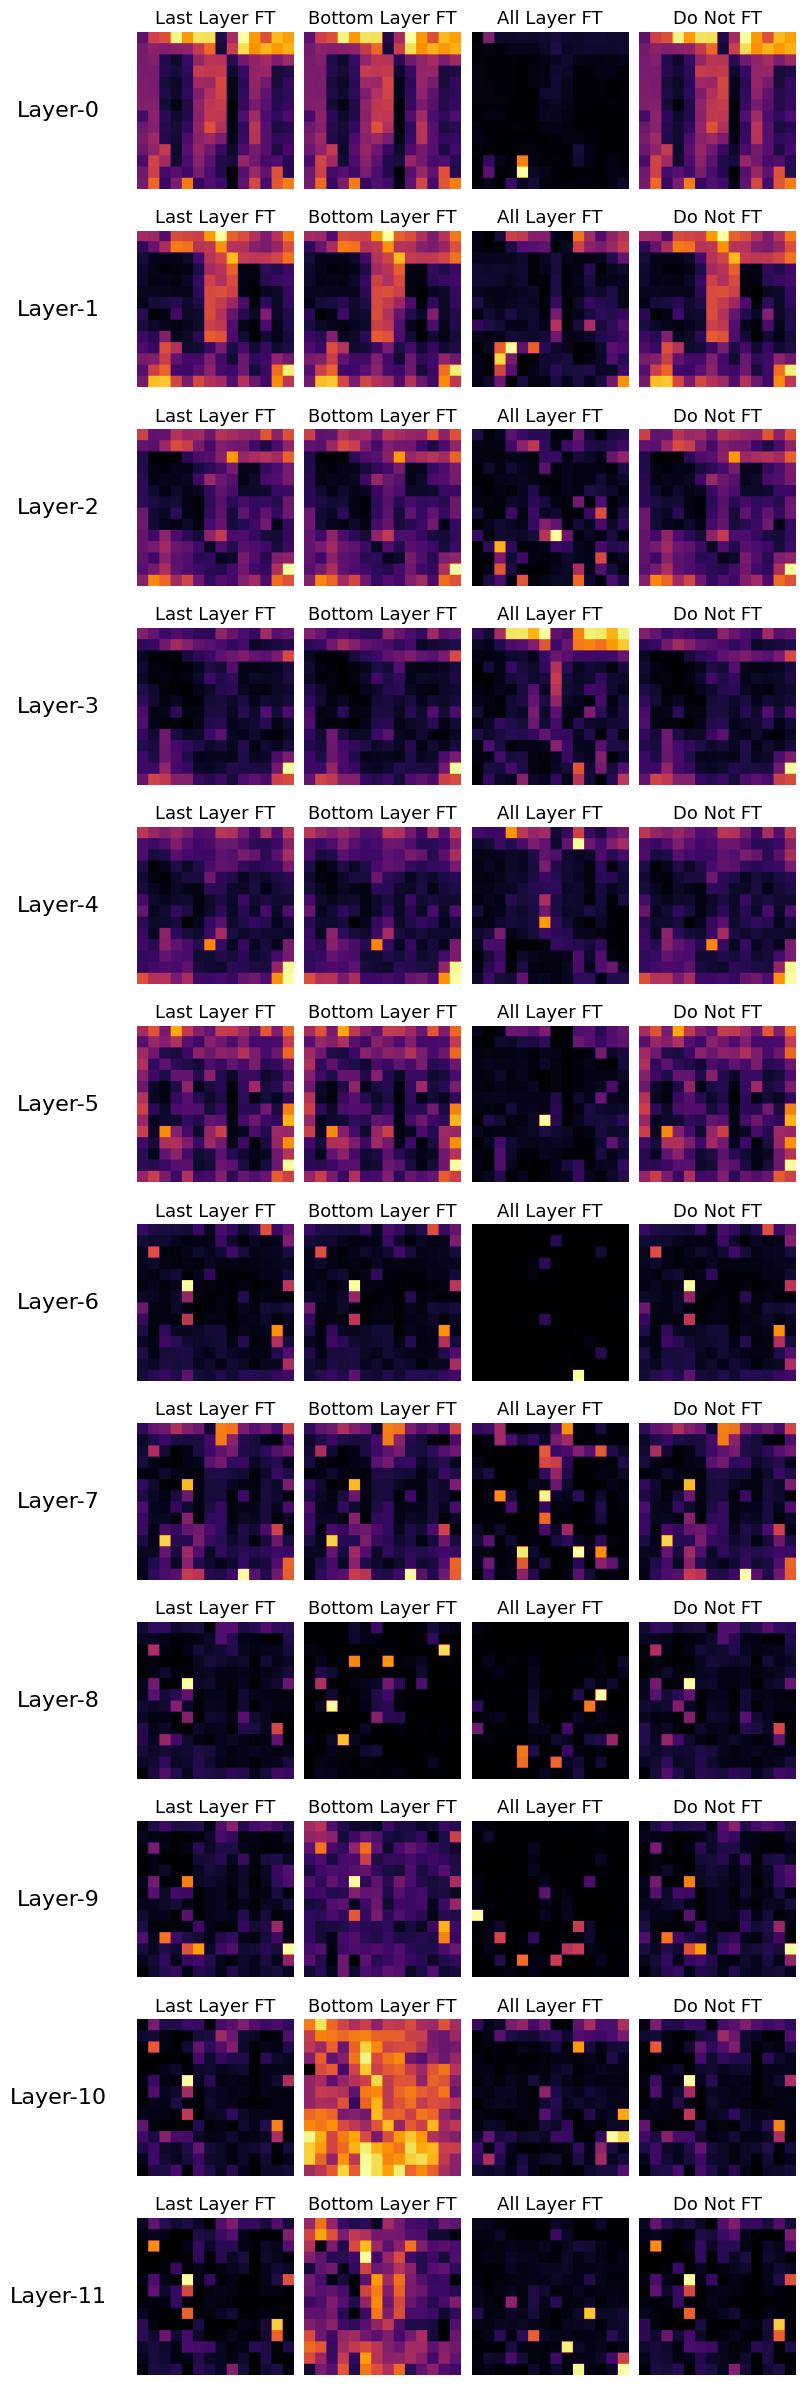

In [21]:
path = "../EuroSAT/2750/AnnualCrop/AnnualCrop_9.jpg"
Ground_Truth = "AnnualCrop"
image_tensor,original_img = pre_process_image(path)
visualize_all_model(image_tensor,original_img,Ground_Truth)

# Label: Forest

Prediction:
Last Layer Fine Tune only:  Forest
Bottom Layer Fine Tune only:  Forest
All layer Tune only:  Forest
Do not Fine-tune:  Residential
Ground Truth:  Forest


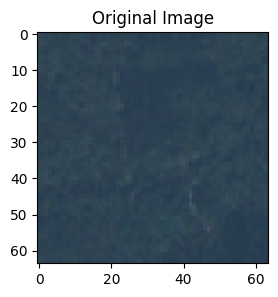

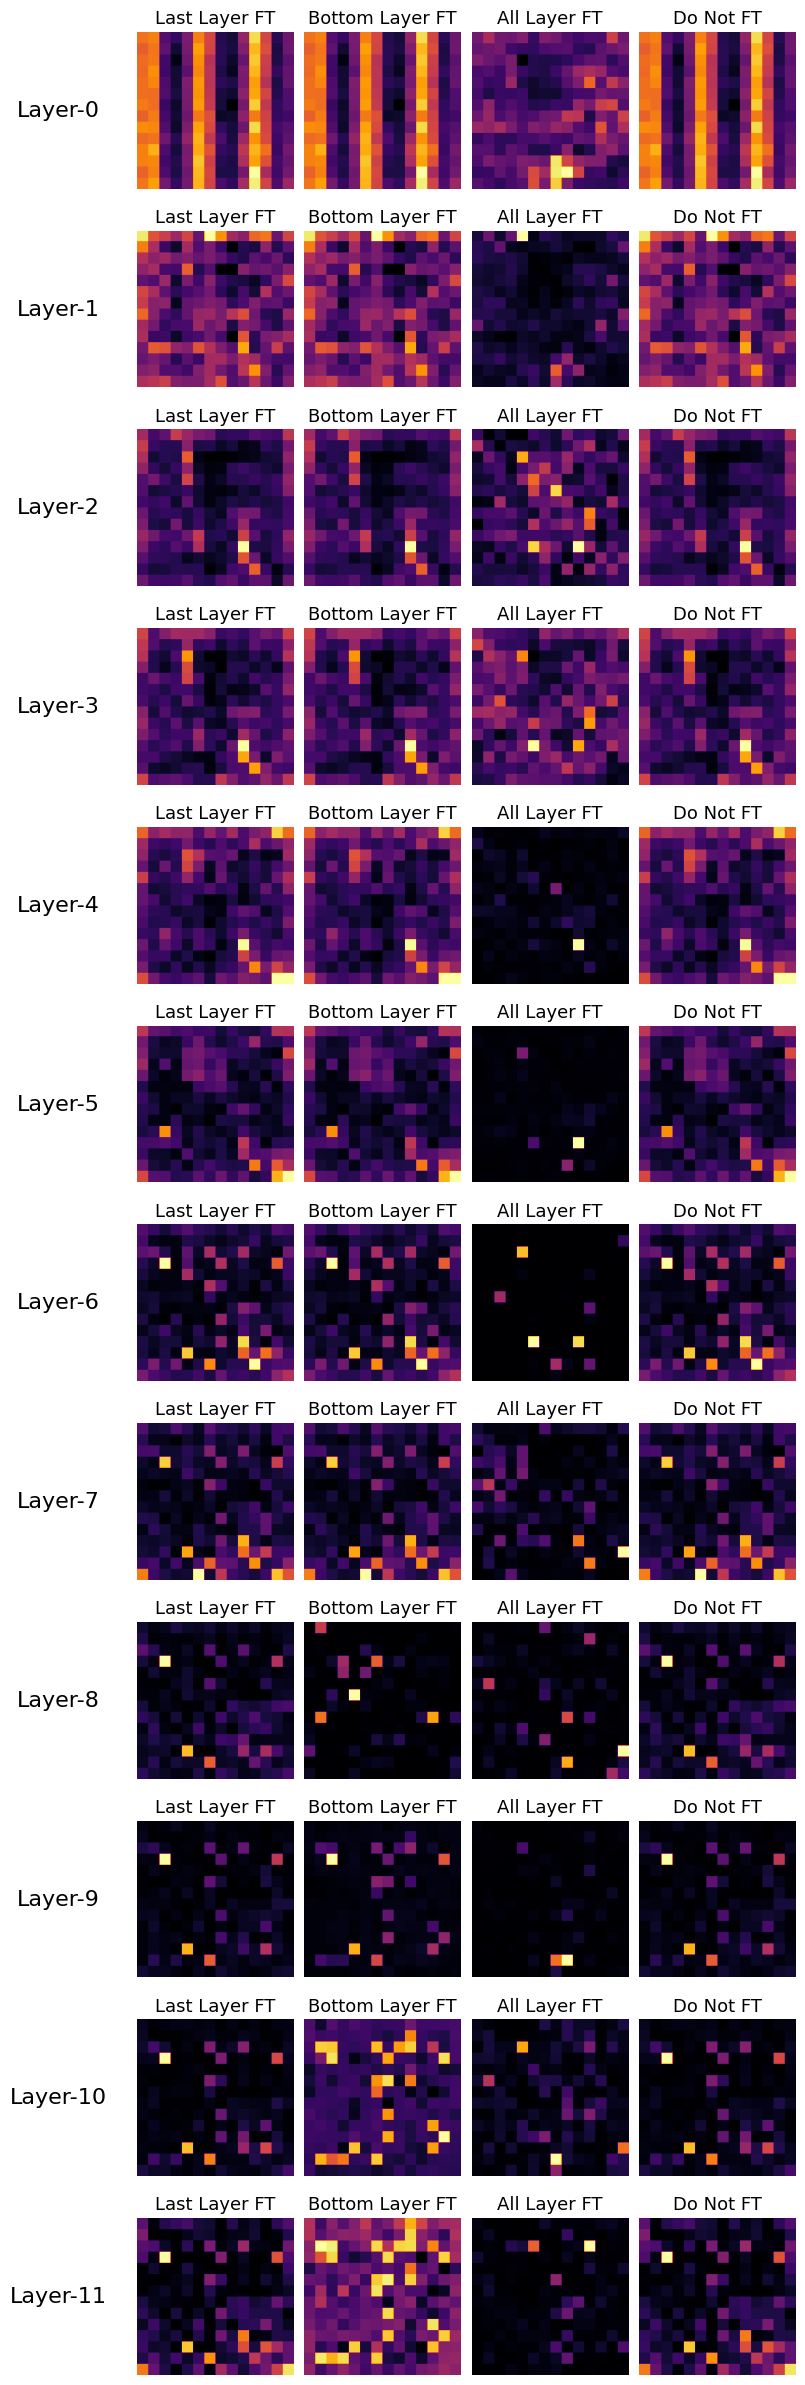

In [22]:
path = "../EuroSAT/2750/Forest/Forest_10.jpg"
Ground_Truth = "Forest"
image_tensor,original_img = pre_process_image(path)
visualize_all_model(image_tensor,original_img,Ground_Truth)

# Label: HerbaceousVegetation

Prediction:
Last Layer Fine Tune only:  HerbaceousVegetation
Bottom Layer Fine Tune only:  HerbaceousVegetation
All layer Tune only:  HerbaceousVegetation
Do not Fine-tune:  Residential
Ground Truth:  HerbaceousVegetation


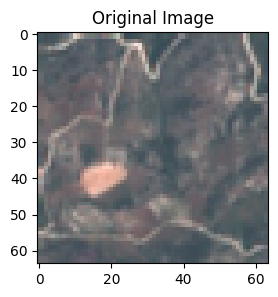

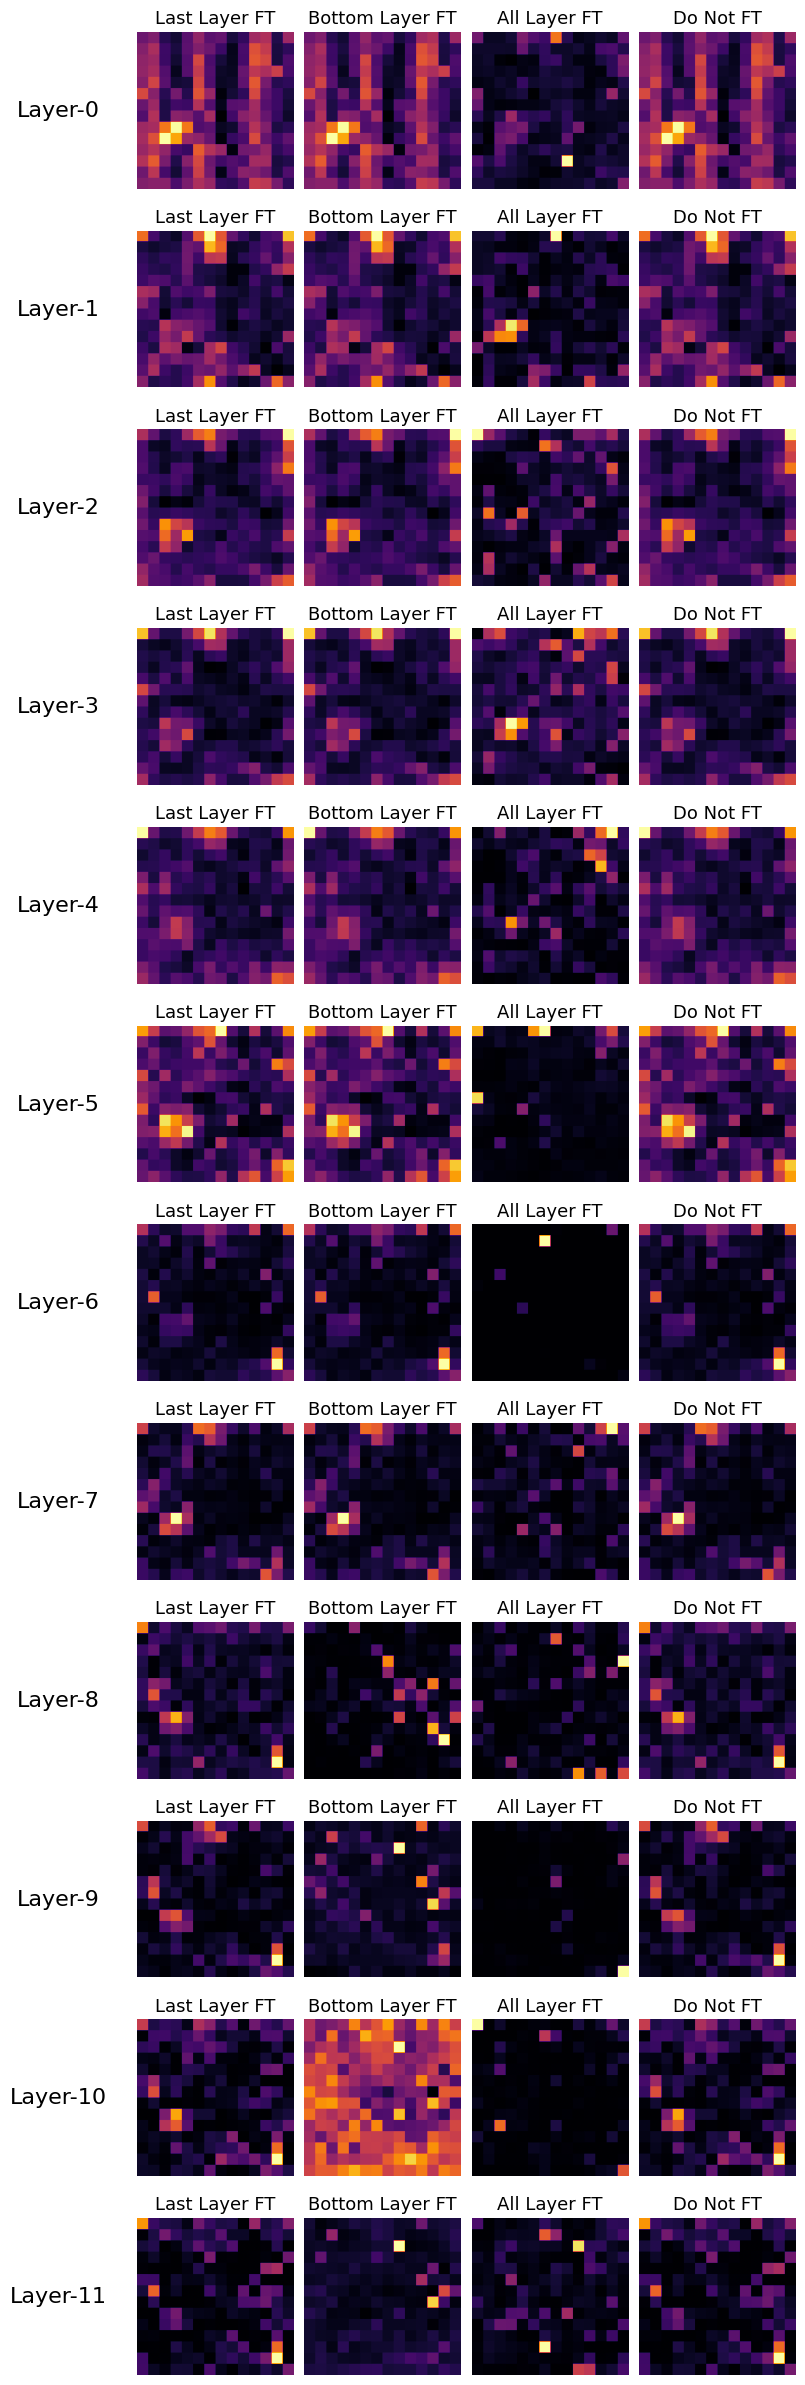

In [23]:
path = "../EuroSAT/2750/HerbaceousVegetation/HerbaceousVegetation_48.jpg"
Ground_Truth = "HerbaceousVegetation"
image_tensor,original_img = pre_process_image(path)
visualize_all_model(image_tensor,original_img,Ground_Truth)

# Label: Highway

Prediction:
Last Layer Fine Tune only:  Highway
Bottom Layer Fine Tune only:  Highway
All layer Tune only:  PermanentCrop
Do not Fine-tune:  Pasture
Ground Truth:  Highway


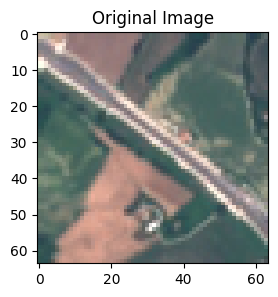

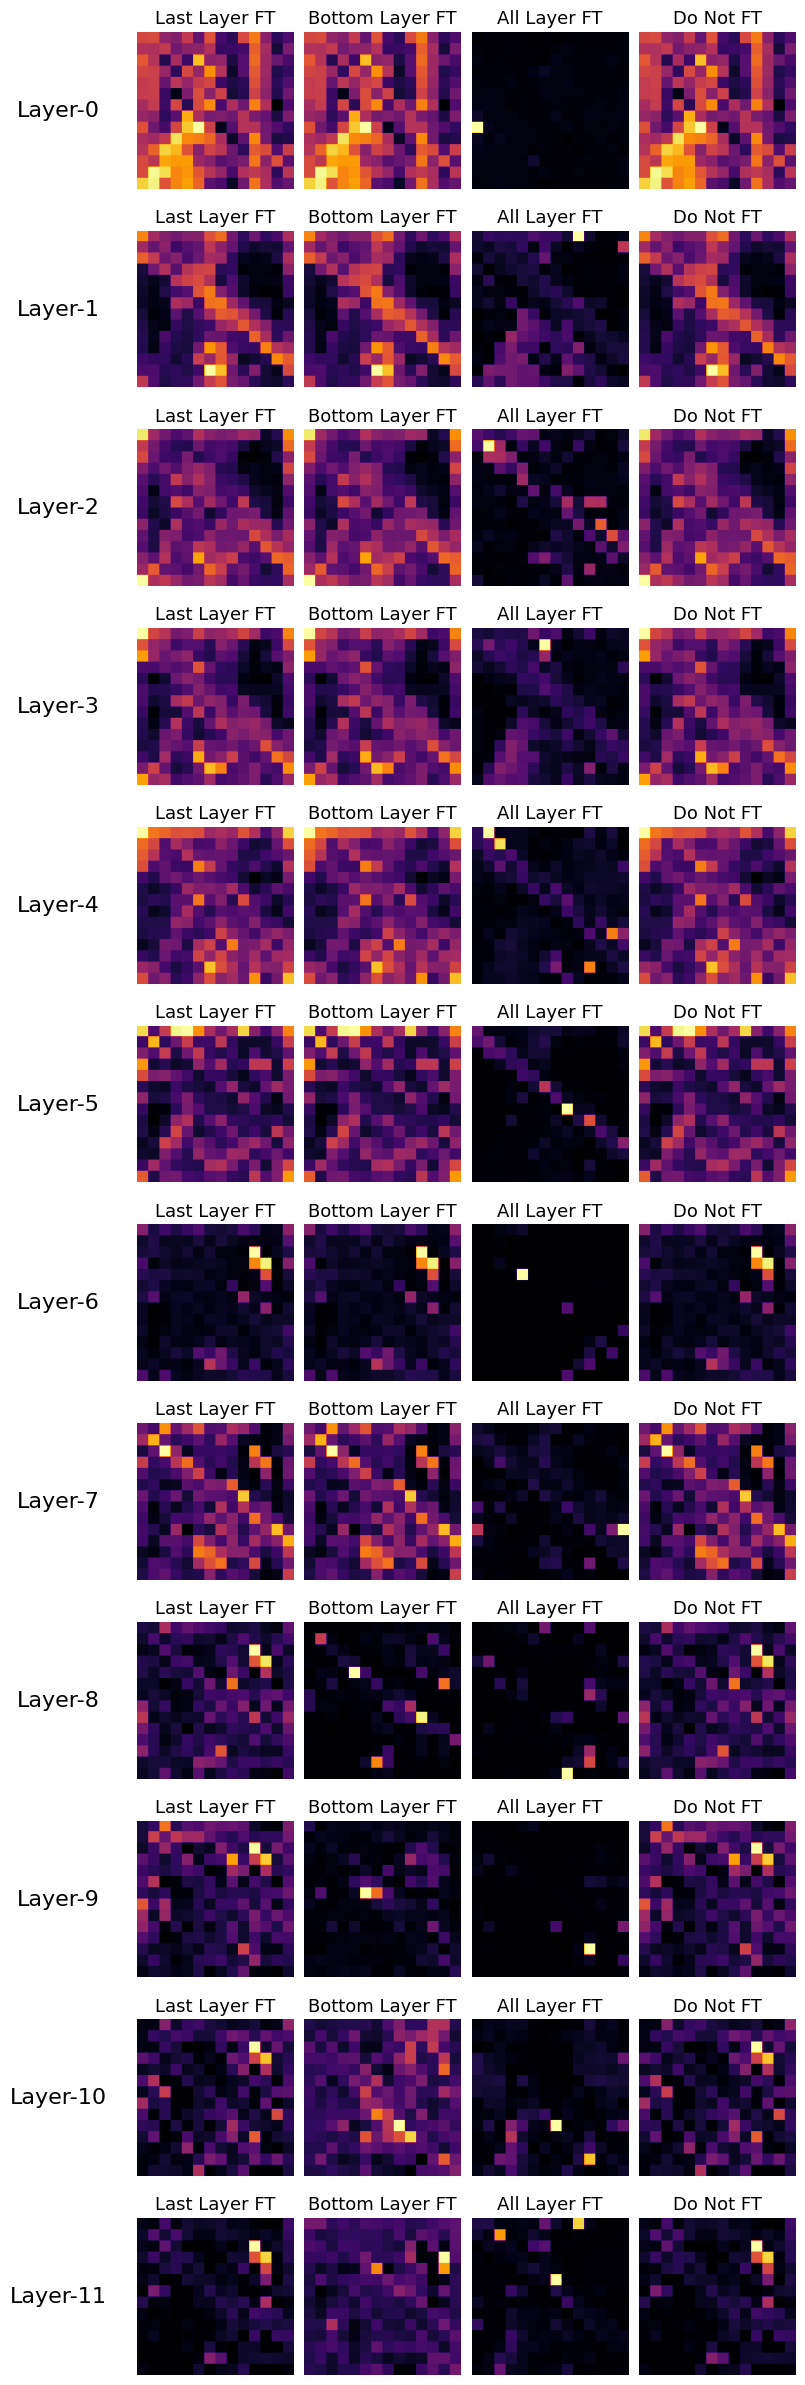

In [24]:
path = "../EuroSAT/2750/Highway/Highway_1.jpg"
Ground_Truth = "Highway"
image_tensor,original_img = pre_process_image(path)
visualize_all_model(image_tensor,original_img,Ground_Truth)

# Label Industrial

Prediction:
Last Layer Fine Tune only:  Industrial
Bottom Layer Fine Tune only:  Industrial
All layer Tune only:  Industrial
Do not Fine-tune:  River
Ground Truth:  Industrial


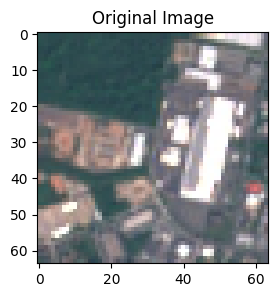

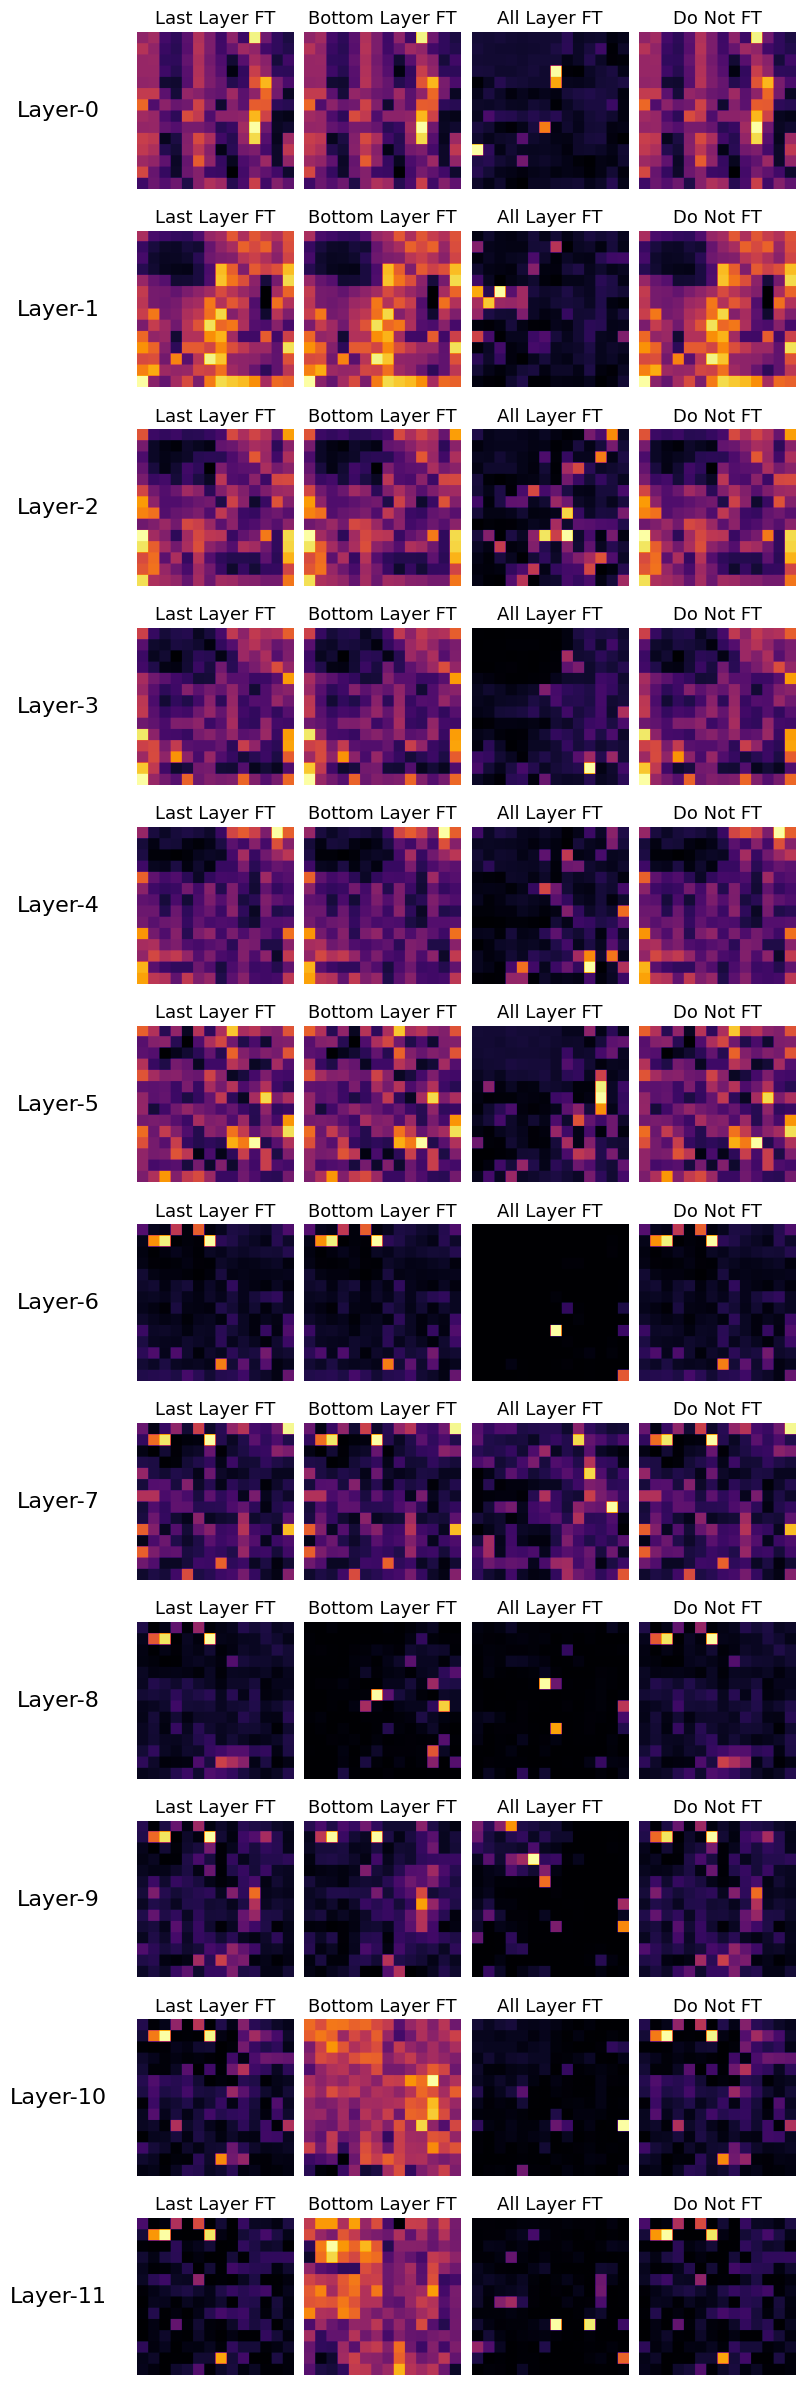

In [25]:
path = "../EuroSAT/2750/Industrial/Industrial_1.jpg"
Ground_Truth = "Industrial"
image_tensor,original_img = pre_process_image(path)
visualize_all_model(image_tensor,original_img,Ground_Truth)

# Label PermanentCrop

Prediction:
Last Layer Fine Tune only:  PermanentCrop
Bottom Layer Fine Tune only:  PermanentCrop
All layer Tune only:  PermanentCrop
Do not Fine-tune:  AnnualCrop
Ground Truth:  PermanentCrop


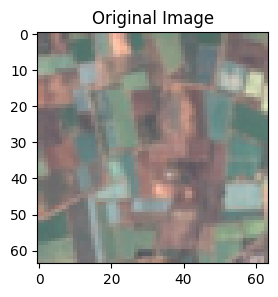

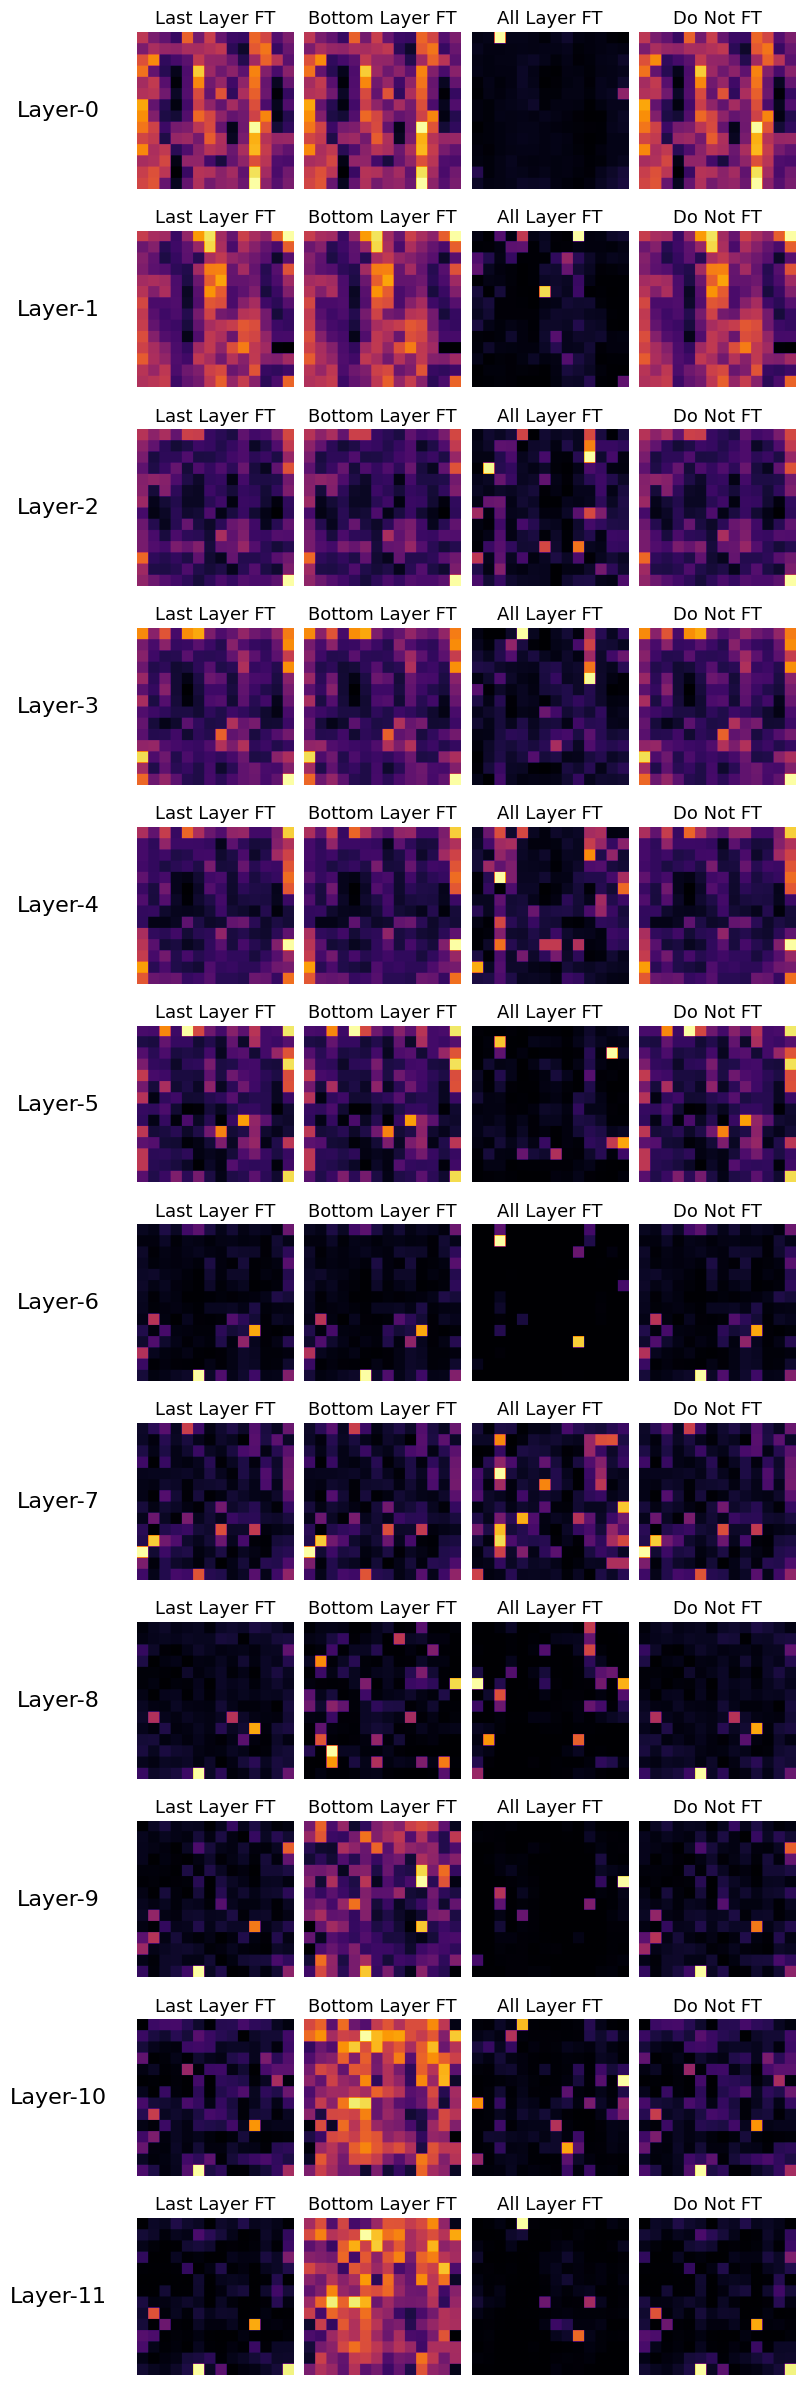

In [26]:
path = "../EuroSAT/2750/PermanentCrop/PermanentCrop_9.jpg"
Ground_Truth = "PermanentCrop"
image_tensor,original_img = pre_process_image(path)
visualize_all_model(image_tensor,original_img,Ground_Truth)

# Label Residential

Prediction:
Last Layer Fine Tune only:  Residential
Bottom Layer Fine Tune only:  Residential
All layer Tune only:  Residential
Do not Fine-tune:  River
Ground Truth:  Residential


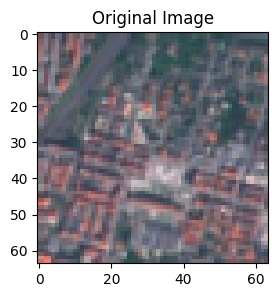

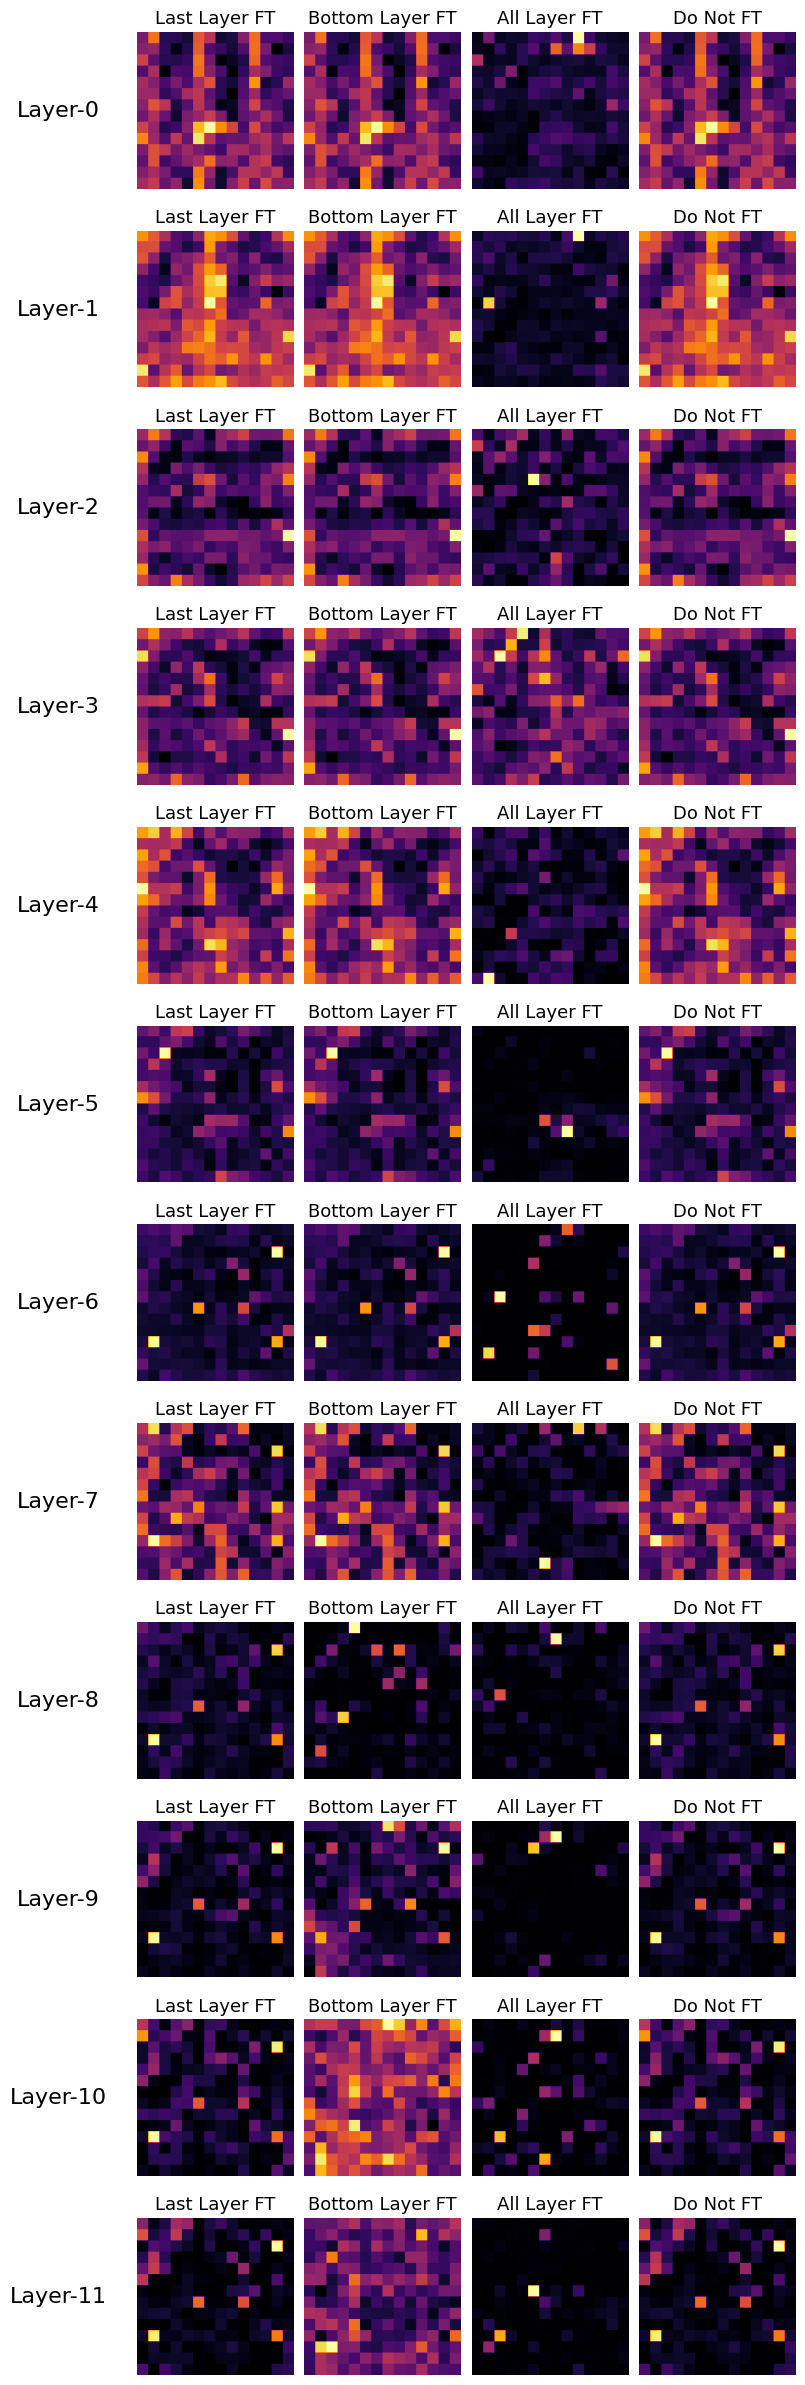

In [27]:
path = "../EuroSAT/2750/Residential/Residential_13.jpg"
Ground_Truth = "Residential"
image_tensor,original_img = pre_process_image(path)
visualize_all_model(image_tensor,original_img,Ground_Truth)

# Label: River

Prediction:
Last Layer Fine Tune only:  River
Bottom Layer Fine Tune only:  River
All layer Tune only:  River
Do not Fine-tune:  HerbaceousVegetation
Ground Truth:  River


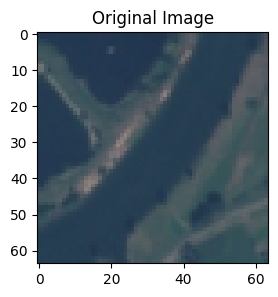

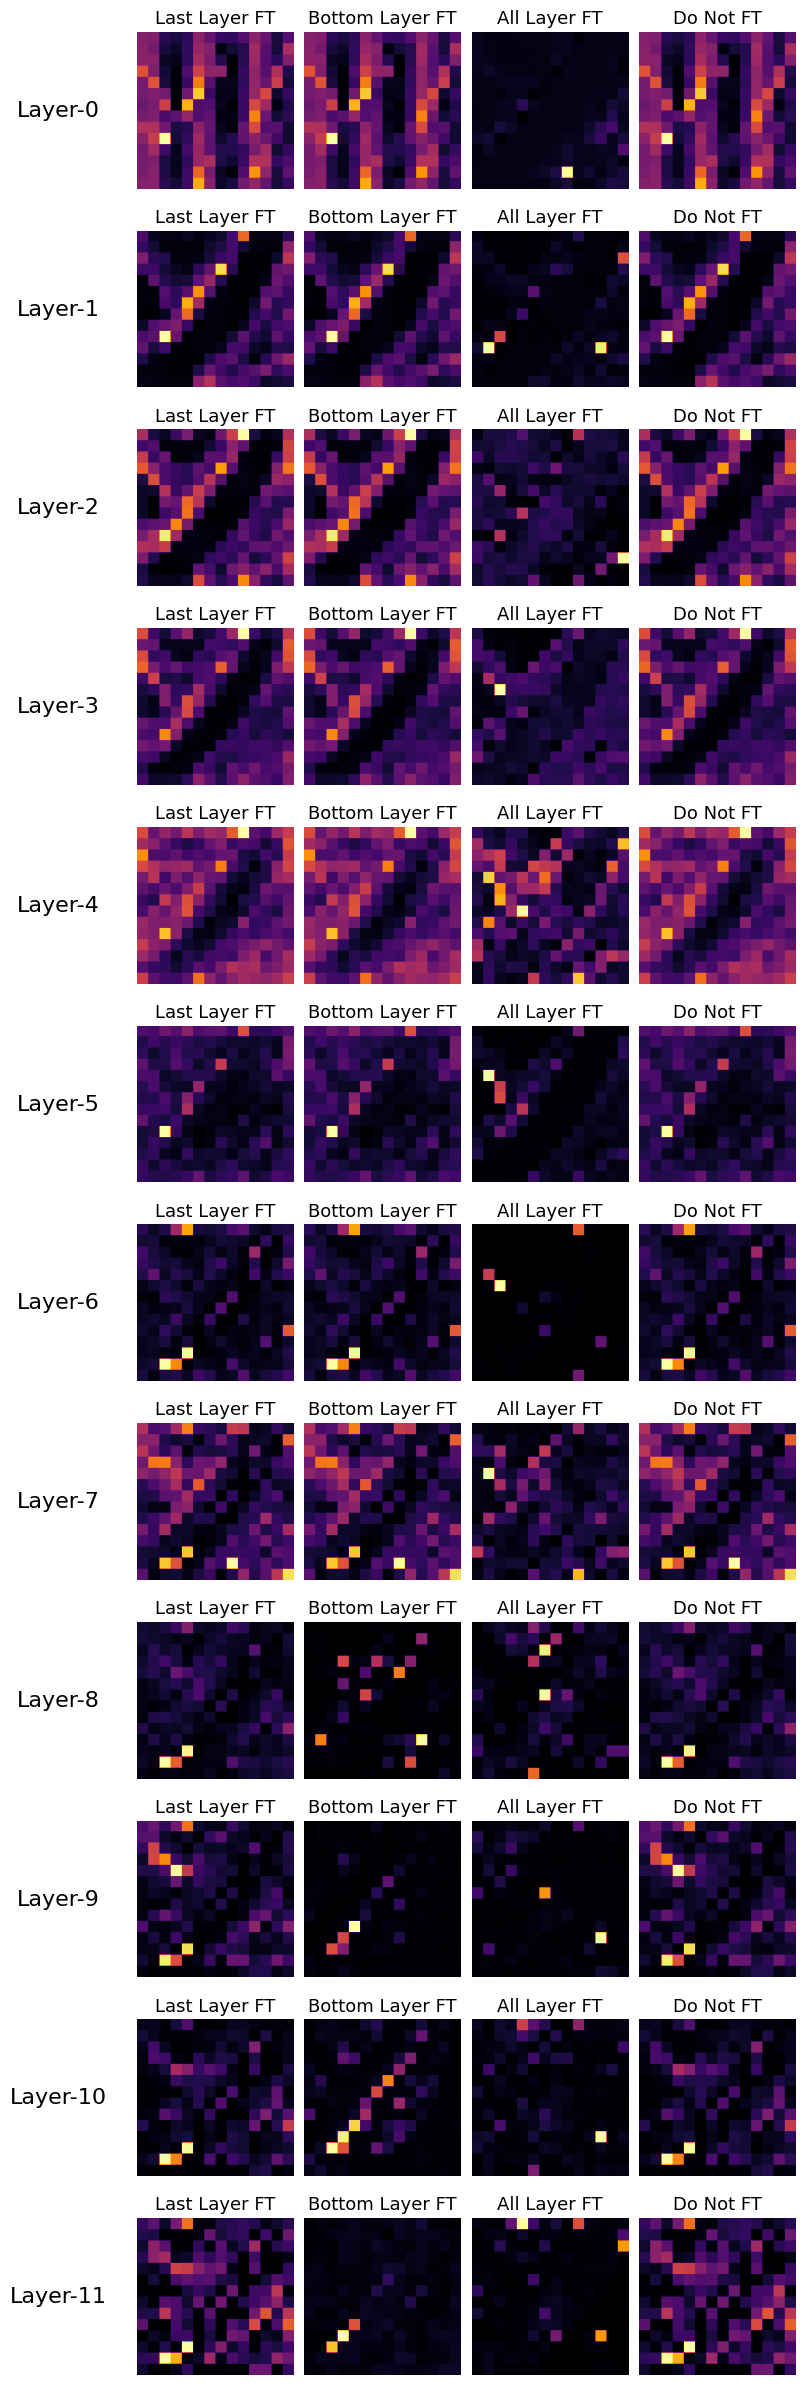

In [28]:
path = "../EuroSAT/2750/River/River_10.jpg"
Ground_Truth = "River"
image_tensor,original_img = pre_process_image(path)
visualize_all_model(image_tensor,original_img,Ground_Truth)

# Label: SeaLake

Prediction:
Last Layer Fine Tune only:  SeaLake
Bottom Layer Fine Tune only:  SeaLake
All layer Tune only:  SeaLake
Do not Fine-tune:  Forest
Ground Truth:  SeaLake


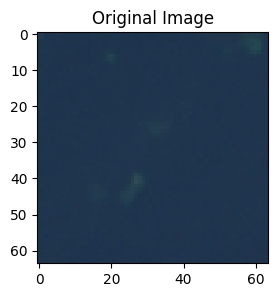

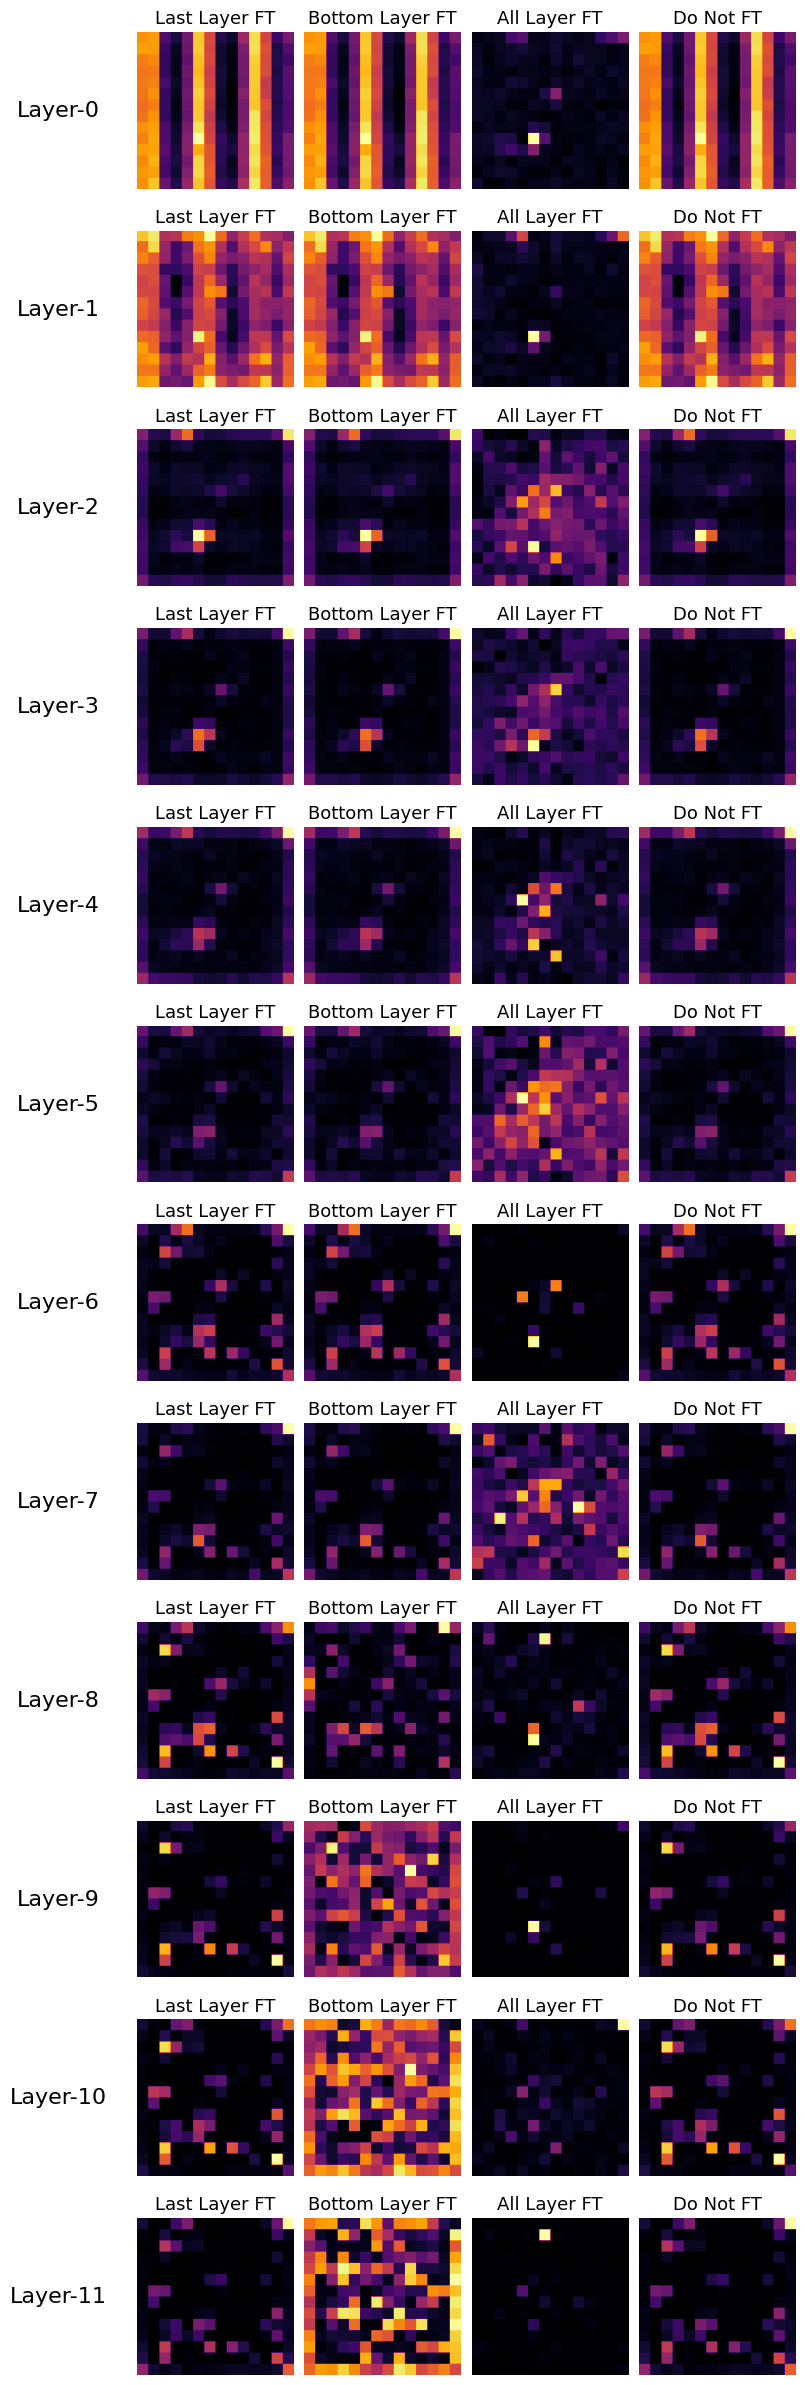

In [29]:
path = "../EuroSAT/2750/SeaLake/SeaLake_10.jpg"
Ground_Truth = "SeaLake"
image_tensor,original_img = pre_process_image(path)
visualize_all_model(image_tensor,original_img,Ground_Truth)